# Vision - Multiclass Image Classification using Pretrained Network [Finetune]

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the implementation of multiclass image classification with pretrained mobilenet using the [Pokemon](https://www.kaggle.com/lantian773030/pokemonclassification) dataset on PyTorch.

In [77]:
import numpy as np
import pandas as pd

import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler


from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

Let's define the path for our data.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = "../../../data/computer_vision/image_classification/pokemon/"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => ../../../data/computer_vision/image_classification/pokemon/


## Define transforms

Let's define a dictionary to hold the image transformations for train/test sets. All images are of size **(300,300)**. We will still resize (to prevent mistakes) all images to have size **(300, 300)** as well as convert the images to tensor. The `ToTensor` operation in PyTorch convert all tensors to lie between (0, 1). 

> `ToTensor` converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

In [5]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

## Initialize Datasets

### Train + Validation Dataset

We 2 dataset folders with us - **Train** and **Test**. 

We will further divide our **Train** set as **Train + Val**. 

In [6]:
pokemon_dataset = datasets.ImageFolder(root = root_dir,
                                       transform = image_transforms["train"]
                                      )

pokemon_dataset

Dataset ImageFolder
    Number of datapoints: 6779
    Root location: ../../../data/computer_vision/image_classification/pokemon/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

### Class <=> ID Mapping of Output

The `class_to_idx` function is pre-built in PyTorch. It returns class ID's present in the dataset.

In [7]:
# pokemon_dataset.class_to_idx

We will now construct a reverse of this dictionary; a mapping of ID to class. 

In [8]:
idx2class = {v: k for k, v in pokemon_dataset.class_to_idx.items()}
# idx2class

Let's also write a function that takes in a dataset object and returns a dictionary that contains the count of class samples. We will use this dictionary to contruct plots and observe the class distribution in our data.

`get_class_distribution()` takes in an argument called `dataset_obj`. 

* We first initialize a `count_dict` dictionary where counts of all classes are initialised to 0. 
* Then, let's iterate through the dataset and increment the counter by 1 for every class label encountered in the loop.


`plot_from_dict()` takes in 3 arguments: a dictionary called `dict_obj`, `plot_title`, and `**kwargs`. We pass in `**kwargs` because later on, we will constuct subplots which require passing the `ax` argument in seaborn. 

* First convert the dictionary to a dataframe. 
* Melt the dataframe and plot.

In [9]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict


def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

In [10]:
# plt.figure(figsize=(15,8))
# plot_from_dict(get_class_distribution(pokemon_dataset), plot_title="Entire Dataset (before train/val/test split)")

### Get Train and Validation Samples

We use `SubsetRandomSampler` to make our train and validation loaders. `SubsetRandomSampler` is used so that our each batch receives a random distribution of classes. 

We could've also split our dataset into 2 parts - train and val ie. make 2 `Subsets`. But this is simpler because our data loader will pretty much handle everything now.



`SubsetRandomSampler(indices)` takes as input the indices of data.

We first create our samplers and then we'll pass it to our dataloaders.

* Create a list of indices.
* Shuffle the indices.
* Split the indices based on train-val percentage.
* Create SubsetRandomSampler.

In [11]:
def create_samplers(dataset, train_percent, val_percent):
    # Create a list of indices from 0 to length of dataset.
    dataset_size = len(dataset)
    dataset_indices = list(range(dataset_size))
    
    # Shuffle the list of indices using `np.shuffle`.
    np.random.shuffle(dataset_indices)
    
    # Create the split index. We choose the split index to be 20% (0.2) of the dataset size.
    train_split_index = int(np.floor(train_percent * dataset_size))
    val_split_index = int(np.floor(val_percent * dataset_size))
    

    # Slice the lists to obtain 2 lists of indices, one for train and other for test.
    # `0-------------------------- train_idx----- val_idx ---------n`

    train_idx = dataset_indices[:train_split_index]
    val_idx = dataset_indices[train_split_index:train_split_index+val_split_index]
    test_idx = dataset_indices[train_split_index+val_split_index:]
    
    # Finally, create samplers.
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    return train_sampler, val_sampler, test_sampler

In [12]:
train_sampler, val_sampler, test_sampler = create_samplers(pokemon_dataset, 0.8, 0.1)

## Train, Validation, and Test Dataloader

Now, we will pass the samplers to our dataloader. Note that `shuffle=True` cannot be used when you're using the `SubsetRandomSampler`.

In [13]:
train_loader = DataLoader(dataset=pokemon_dataset, shuffle=False, batch_size=8, sampler = train_sampler)
val_loader = DataLoader(dataset=pokemon_dataset, shuffle=False, batch_size=1, sampler = val_sampler)
test_loader = DataLoader(dataset=pokemon_dataset, shuffle=False, batch_size=1, sampler = test_sampler)

## Explore The Data

To explore our train and val dataloaders, let's create a new function that takes in a dataloader and returns a dictionar with class counts. 

* Intialize a dictionary `count_dict` to all 0s.
* If the batch_size of the `dataloader_obj` is 1, then loop through the `dataloader_obj` and update the counter. 
* Else, if the batch_size of the `dataloader_obj` is **not** 1, then loop through the `dataloader_obj` to obtain batches. Loop through the batches to obtain individual tensors. Now, updated the counter accordingly. 

In [14]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
        
            
    return count_dict

To plot the class distributions, we will use the `plot_from_dict()` function defined earlier with the `ax` argument.

In [15]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

# plot_from_dict(get_class_distribution_loaders(train_loader, rps_dataset), plot_title="Train Set", ax=axes[0])
# plot_from_dict(get_class_distribution_loaders(val_loader, rps_dataset), plot_title="Val Set", ax=axes[1])

Now that we've looked at the class distributions, Let's now look at a single image.

In [16]:
single_batch = next(iter(train_loader))

`single_batch` is a list of 2 elements. The first element (0th index) contains the image tensors while the second element (1st index) contains the output labels. 

Here's the first element of the list which is a tensor. This tensor is of the shape `(batch, channels, height, width)`. 

In [17]:
single_batch[0].shape

torch.Size([8, 3, 224, 224])

Here are the output labels for the batch.

In [18]:
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

Output label tensors:  tensor([ 89,  48, 126,  26, 143,  72,   4, 132])

Output label tensor shape:  torch.Size([8])


To plot the image, we'll use `plt.imshow` from matloptlib. It expects the image dimension to be `(height, width, channels)`. We'll `.permute()` our single image tensor to plot it. 

In [19]:
# Selecting the first image tensor from the batch. 
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


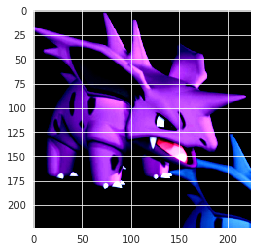

In [20]:
plt.imshow(single_image.permute(1, 2, 0))

PyTorch has made it easier for us to plot the images in a grid straight from the batch. 

We first extract out the image tensor from the list (returned by our dataloader) and set `nrow`. Then we use the `plt.imshow()` function to plot our grid. Remember to `.permute()` the tensor dimensions!

In [21]:
# We do single_batch[0] because each batch is a list 
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


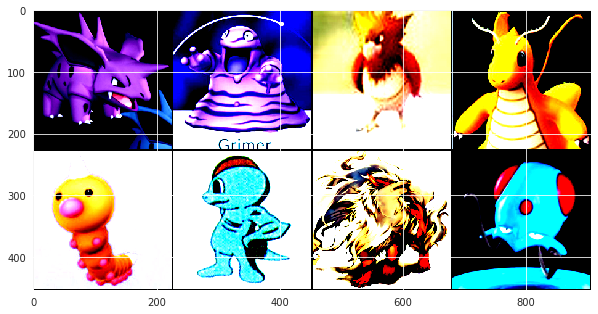

In [22]:
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

## Define a CNN Architecture

We will fine tune a pretrained `mobilenet`, takek from `torchvision`, for this task.

In [23]:
model = models.mobilenet_v2(pretrained=True, progress=True)

In [24]:
model.classifier[1] = nn.Linear(1280, len(idx2class))

Now we'll initialize the model, optimizer, and loss function. 

Then we'll transfer the model to GPU. 

We're using the `nn.CrossEntropyLoss` .

We don't have to manually apply a `log_softmax` layer after our final layer because `nn.CrossEntropyLoss` does that for us.

However, we need to apply `log_softmax` for our validation and testing.

In [30]:
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

Before we start our training, let's define a function to calculate accuracy per epoch. 

This function takes `y_pred` and `y_test` as input arguments. We then apply softmax to `y_pred` and extract the class which has a higher probability.

After that, we compare the the predicted classes and the actual classes to calculate the accuracy.

In [31]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

We'll also define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.

In [32]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

Let's TRAIN our model!

You can see we've put a `model.train()` at the before the loop. `model.train()` tells PyTorch that you're in training mode. Well, why do we need to do that? If you're using layers such as `Dropout` or `BatchNorm` which behave differently during training and evaluation (for eample; not use `dropout` during evalualtion), you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, so, you don't explicitly have to write that. But it's good practice.

Similarly, we'll call `model.eval()` when we test our model. We'll see that below. Back to training; we start a for-loop. At the top of this for-loop, we initialize our loss and accuracy per epoch to 0. After every epoch, we'll print out the loss/accuracy and reset it back to 0.

Then we have another for-loop. This for-loop is used to get our data in batches from the `train_loader`.

We do `optimizer.zero_grad()` before we make any predictions. Since the `.backward()` function accumulates gradients, we need to set it to 0 manually per mini-batch. From our defined model, we then obtain a prediction, get the loss(and accuracy) for that mini-batch, perform backpropagation using loss.backward() and optimizer.step().  


Finally, we add all the mini-batch losses (and accuracies) to obtain the average loss (and accuracy) for that epoch. We add up all the losses/accuracies for each minibatch and finally divide it by the number of minibatches ie. length of `train_loader` to obtain the average loss/accuracy per epoch.

The procedure we follow for training is the exact same for validation except for the fact that we wrap it up in `torch.no_grad` and not perform any backpropagation. `torch.no_grad()` tells PyTorch that we do not want to perform back-propagation, which reduces memory usage and speeds up computation.

In [33]:
print("Begin training.")

for e in tqdm(range(1, 11)):
    
    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch).squeeze()
                
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch).squeeze()
            
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 01: | Train Loss: 3.25410 | Val Loss: 2.26073 | Train Acc: 26.844| Val Acc: 0.000
Epoch 02: | Train Loss: 1.03385 | Val Loss: 0.66227 | Train Acc: 95.575| Val Acc: 100.000
Epoch 03: | Train Loss: 0.49748 | Val Loss: 0.31431 | Train Acc: 99.705| Val Acc: 100.000
Epoch 04: | Train Loss: 0.29419 | Val Loss: 0.08844 | Train Acc: 99.853| Val Acc: 100.000
Epoch 05: | Train Loss: 0.18831 | Val Loss: 0.13571 | Train Acc: 100.000| Val Acc: 100.000
Epoch 06: | Train Loss: 0.13243 | Val Loss: 0.15847 | Train Acc: 100.000| Val Acc: 100.000
Epoch 07: | Train Loss: 0.09009 | Val Loss: 0.01225 | Train Acc: 100.000| Val Acc: 100.000
Epoch 08: | Train Loss: 0.07117 | Val Loss: 0.03374 | Train Acc: 100.000| Val Acc: 100.000
Epoch 09: | Train Loss: 0.05564 | Val Loss: 0.10270 | Train Acc: 100.000| Val Acc: 100.000
Epoch 10: | Train Loss: 0.04389 | Val Loss: 0.08442 | Train Acc: 100.000| Val Acc: 100.000



## Visualize Loss and Accuracy

To plot the loss and accuracy line plots, we again create a dataframe from the `accuracy_stats` and `loss_stats` dictionaries.

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

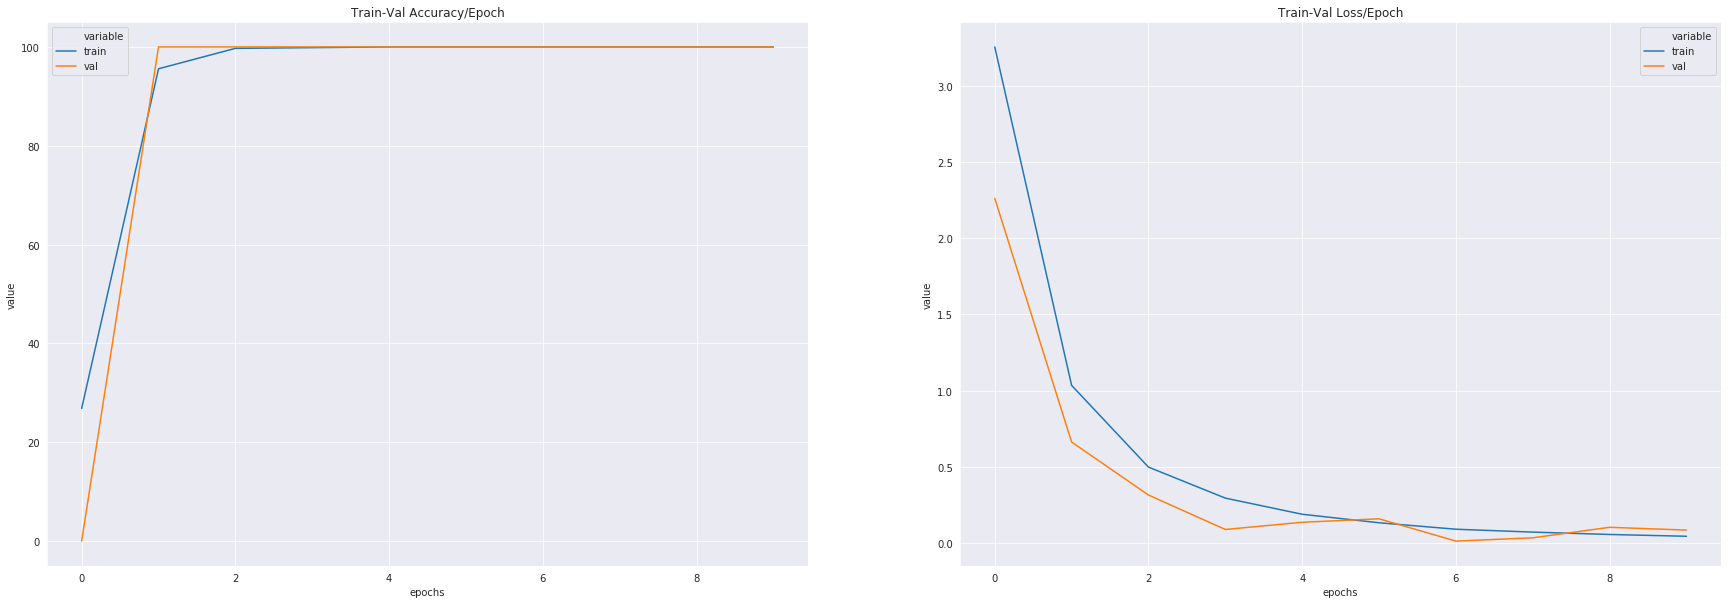

In [34]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Test

After training is done, we need to test how our model fared. Note that we've used `model.eval()` before we run our testing code.
To tell PyTorch that we do not want to perform back-propagation during inference, we use `torch.no_grad()`, just like we did it for the validation loop above.

* We start by defining a list that will hold our predictions. Then we loop through our batches using the `test_loader`. For each batch -
* We move our input mini-batch to GPU.
* We make the predictions using our trained model.
* Apply log_softmax activation to the predictions and pick the index of highest probability.
* Move the batch to the GPU from the CPU.
* Convert the tensor to a numpy object and append it to our list.

In [35]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

We'll flatten out the list so that we can use it as an input to `confusion_matrix` and `classification_report`.

In [48]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

## Classification Report

Finally, we print out the classification report which contains the precision, recall, and the F1 score.

In [75]:
# print(classification_report(y_true_list, y_pred_list))
print(f"Accuracy = {accuracy_score(y_true_list, y_pred_list) * 100}")
print(f"Precision = {precision_score(y_true_list, y_pred_list, average='weighted') * 100}")
print(f"Recall = {recall_score(y_true_list, y_pred_list, average='weighted') * 100}")
print(f"F1 Score = {f1_score(y_true_list, y_pred_list, average='weighted') * 100}")

Accuracy = 95.28718703976435
Precision = 96.1931645510438
Recall = 95.28718703976435
F1 Score = 95.19580908084762


## Confusion Matrix

We create a dataframe from the confusion matrix and plot it as a heatmap using the seaborn library.

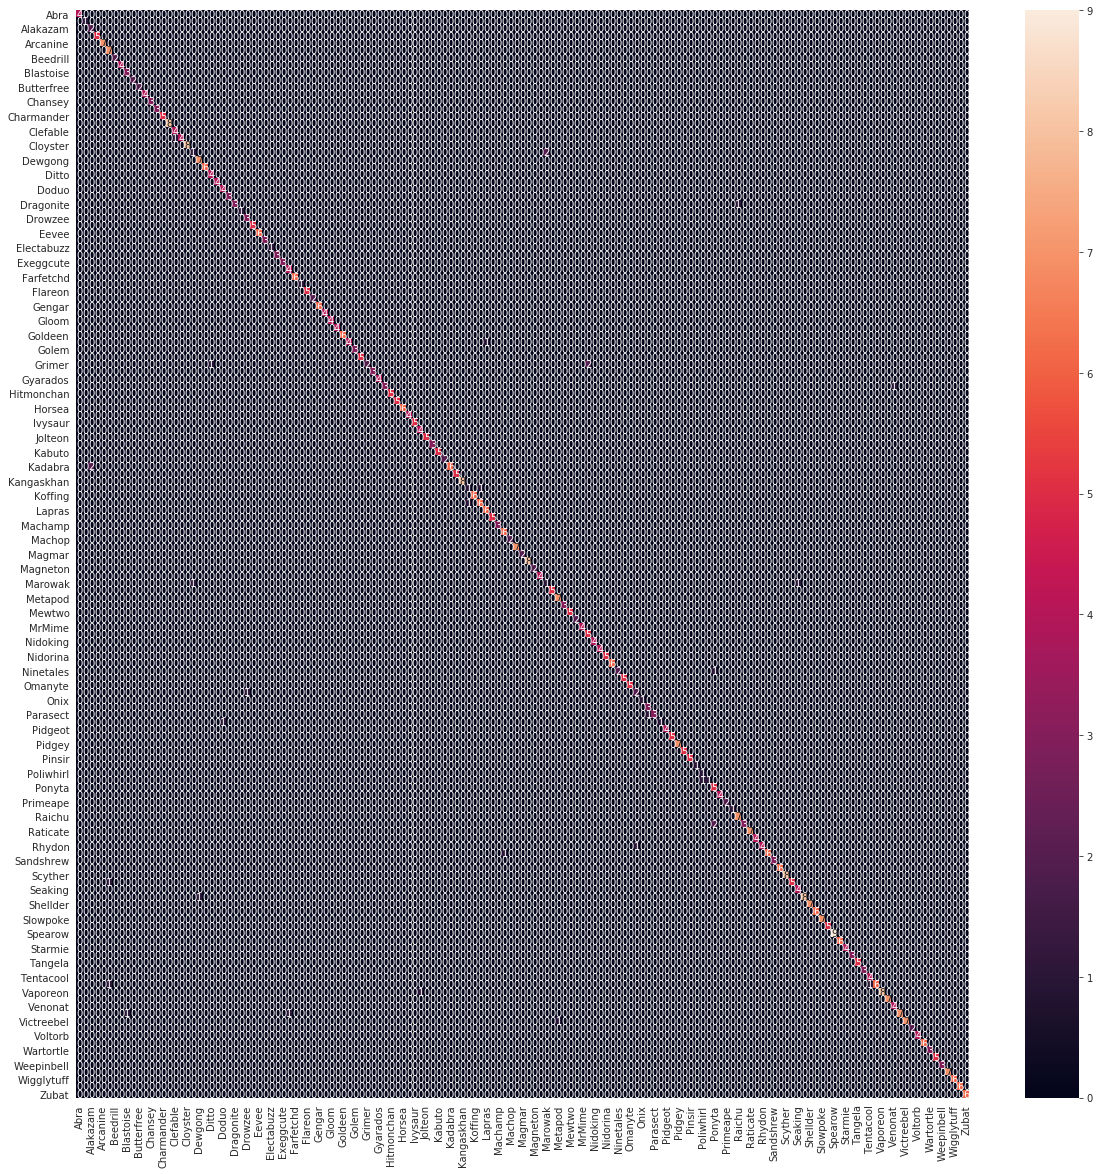

In [53]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)

fig, ax = plt.subplots(figsize=(20,20))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

## Inference

In [142]:
test_loader_iter = iter(test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Class = Seaking
Pred Class = Seaking


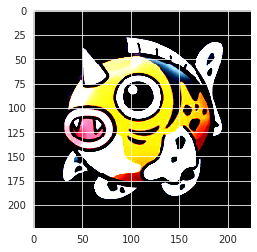

In [151]:
single_img, single_lbl = next(test_loader_iter)
single_img, single_lbl = single_img.to(device), single_lbl.to(device)

pred = torch.log_softmax(model(single_img), dim = 1)
_, pred_class = torch.max(pred, dim = 1)
pred_class = pred_class.item()

single_img = single_img.squeeze().permute(1, 2, 0).cpu().numpy()
print(f"True Class = {idx2class[single_lbl.item()]}")
print(f"Pred Class = {idx2class[pred_class]}")

plt.imshow(single_img)